<a href="https://colab.research.google.com/github/upamada-ekanayake/AI-Student-Focus-Monitor/blob/main/Student_Focus_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Student Support AI
**Author:** Upamada Ekanayake
**Goal:** A mental health helper bot using NLP.

In [1]:
# This installs MediaPipe (the AI that sees faces) and OpenCV (the camera tool)
!pip install mediapipe opencv-python

In [2]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


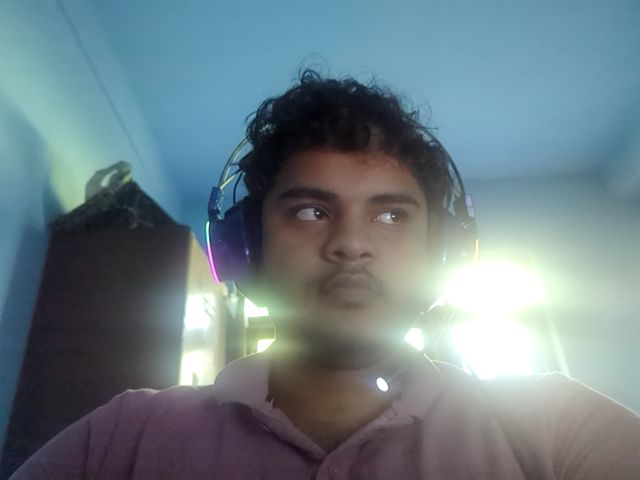

In [4]:
# This commands the computer to take a photo using the tool we made above
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  from IPython.display import Image
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

/usr/local/lib/python3.12/dist-packages/jaxlib/plugin_support.py:71: RuntimeWarning: JAX plugin jax_cuda12_plugin version 0.7.2 is installed, but it is not compatible with the installed jaxlib version 0.7.1, so it will not be used.
  warnings.warn(


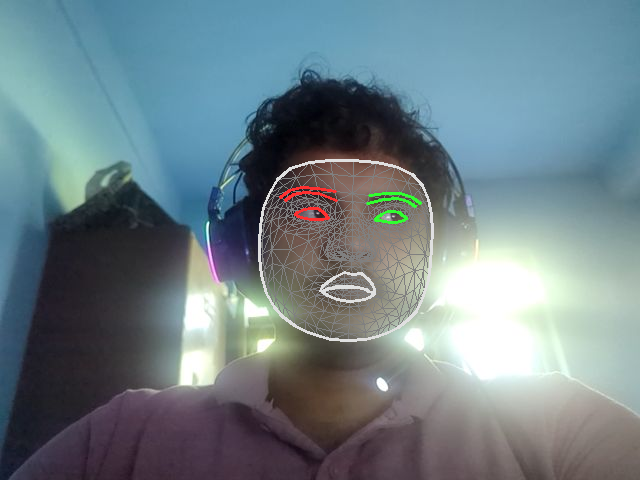

In [7]:
import cv2
import mediapipe as mp
from google.colab.patches import cv2_imshow # Special tool to show images in Colab

# 1. Setup the Face Mesh Tool
mp_face_mesh = mp.solutions.face_mesh
mp_drawing = mp.solutions.drawing_utils # Tool to draw lines
mp_drawing_styles = mp.solutions.drawing_styles

# 2. Read the image we took in Step 1
image_path = 'photo.jpg'
image = cv2.imread(image_path)

# 3. Create the Face Mesh Processor
# static_image_mode=True means we are checking a single photo, not a video yet.
with mp_face_mesh.FaceMesh(
    static_image_mode=True,
    max_num_faces=1,
    refine_landmarks=True,
    min_detection_confidence=0.5) as face_mesh:

    # 4. Process the image to find the face
    # We convert BGR (Blue-Green-Red) to RGB because MediaPipe likes RGB better.
    results = face_mesh.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    # 5. Draw the mesh on the face
    if results.multi_face_landmarks:
      for face_landmarks in results.multi_face_landmarks:

        # Draw the "Tesselation" (the net/grid on the face)
        mp_drawing.draw_landmarks(
            image=image,
            landmark_list=face_landmarks,
            connections=mp_face_mesh.FACEMESH_TESSELATION,
            landmark_drawing_spec=None,
            connection_drawing_spec=mp_drawing_styles.get_default_face_mesh_tesselation_style())

        # Draw the eyes and eyebrows specifically
        mp_drawing.draw_landmarks(
            image=image,
            landmark_list=face_landmarks,
            connections=mp_face_mesh.FACEMESH_CONTOURS,
            landmark_drawing_spec=None,
            connection_drawing_spec=mp_drawing_styles.get_default_face_mesh_contours_style())

      # 6. Show the final result
      cv2_imshow(image)
    else:
      print("No face found! Make sure your photo is clear.")

In [8]:
import math

# 1. Define the specific numbered dots for eyes
LEFT_EYE = [33, 160, 158, 133, 153, 144]
RIGHT_EYE = [362, 385, 387, 263, 373, 380]

# 2. This function calculates the distance between two dots
def euclidean_distance(point1, point2):
    x1, y1 = point1.x, point1.y
    x2, y2 = point2.x, point2.y
    distance = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    return distance

# 3. This function calculates the Blink Ratio (EAR)
def calculate_blink_ratio(landmarks, eye_indices):
    # Get the specific points for the eye
    # Horizontal line (corner to corner)
    p1 = landmarks[eye_indices[0]] # Left corner
    p4 = landmarks[eye_indices[3]] # Right corner

    # Vertical lines (top lid to bottom lid)
    p2 = landmarks[eye_indices[1]]
    p6 = landmarks[eye_indices[5]]

    p3 = landmarks[eye_indices[2]]
    p5 = landmarks[eye_indices[4]]

    # Calculate distances
    # Distance between vertical points (Height)
    up_down_1 = euclidean_distance(p2, p6)
    up_down_2 = euclidean_distance(p3, p5)

    # Distance between horizontal points (Width)
    left_right = euclidean_distance(p1, p4)

    # The Math Formula
    ratio = (up_down_1 + up_down_2) / (2.0 * left_right)
    return ratio

# 4. Let's test it on your photo from Step 2!
if results.multi_face_landmarks:
    for face_landmarks in results.multi_face_landmarks:
        # Get the list of all 468 dots
        landmarks = face_landmarks.landmark

        # Calculate ratio for both eyes
        left_ear = calculate_blink_ratio(landmarks, LEFT_EYE)
        right_ear = calculate_blink_ratio(landmarks, RIGHT_EYE)

        # Average them (in case you wink with one eye)
        avg_ear = (left_ear + right_ear) / 2

        print(f"Left Eye Ratio: {left_ear:.2f}")
        print(f"Right Eye Ratio: {right_ear:.2f}")
        print(f"Average Ratio: {avg_ear:.2f}")

        # The Decision Logic
        if avg_ear < 0.20: # Threshold (You can adjust this number)
            print("STATUS: 😴 SLEEPING / BLINKING")
        else:
            print("STATUS: 👀 AWAKE")

Left Eye Ratio: 0.40
Right Eye Ratio: 0.42
Average Ratio: 0.41
STATUS: 👀 AWAKE
